# Steps
1. getting packages, libraries, classes and dataset
2. Preprocessing - Multi indexing, One-hot encoding, scaling, imputing, feature engineering
3. Training model with appropriate configurations
4. Making a function to generate results in a suitable format and getting results
5. Making plots to see uncertainties
6. ReCalibrating and ploting differences compared with appropriate metrics.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.utils.data as data_utils
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from IPython import display
import os
from torch.utils.data.dataset import Dataset
from uq360.algorithms.variational_bayesian_neural_networks.bnn import BnnClassification
from uq360.metrics.classification_metrics import entropy_based_uncertainty_decomposition, plot_risk_vs_rejection_rate

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.compose import make_column_transformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import OneHotEncoder

from aif360.sklearn.datasets import fetch_adult
from aif360.sklearn.metrics import disparate_impact_ratio, average_odds_error, generalized_fpr, statistical_parity_difference, equal_opportunity_difference
from aif360.sklearn.metrics import generalized_fnr, difference

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
X, y, sample_weight = fetch_adult()
X.head()

age  workclass     education  education-num  \
race      sex                                                  
Non-white Male  25.0    Private          11th            7.0   
White     Male  38.0    Private       HS-grad            9.0   
          Male  28.0  Local-gov    Assoc-acdm           12.0   
Non-white Male  44.0    Private  Some-college           10.0   
White     Male  34.0    Private          10th            6.0   

                    marital-status         occupation   relationship   race  \
race      sex                                                                 
Non-white Male       Never-married  Machine-op-inspct      Own-child  Black   
White     Male  Married-civ-spouse    Farming-fishing        Husband  White   
          Male  Married-civ-spouse    Protective-serv        Husband  White   
Non-white Male  Married-civ-spouse  Machine-op-inspct        Husband  Black   
White     Male       Never-married      Other-service  Not-in-family  White   

                 sex  capital-gain  capital-loss  hours-per-week  \
race      sex                                                      
Non-white Male  Male           0.0           0.0            40.0   
White     Male  Male           0.0           0.0            50.0   
          Male  Male           0.0           0.0            40.0   
Non-white Male  Male        7688.0           0.0            40.0   
White     Male  Male           0.0           0.0            30.0   

               native-country  
race      sex                  
Non-white Male  United-States  
White     Male  United-States  
          Male  United-States  
Non-white Male  United-States  
White     Male  United-States

In [5]:
X.shape

(45222, 13)

In [6]:
X.index = pd.MultiIndex.from_arrays(X.index.codes, names=X.index.names)
y.index = pd.MultiIndex.from_arrays(y.index.codes, names=y.index.names)

In [7]:
y = pd.Series(y.factorize(sort=True)[0], index=y.index)

In [8]:
(X_train, X_test,
 y_train, y_test) = train_test_split(X, y, train_size=0.7, random_state=1234567)
(X_train, X_calib,
 y_train, y_calib) = train_test_split(X_train, y_train, train_size=0.7, random_state=1234567)

In [9]:
y_train

race  sex
0     0      1
1     0      0
      1      1
      0      0
      1      1
            ..
      1      0
      1      0
      1      0
      0      0
      1      1
Length: 22158, dtype: int64

In [10]:
X_train["sex"]=="Male"

race  sex
0     0      False
1     0      False
      1       True
      0      False
      1       True
             ...  
      1       True
      1       True
      1       True
      0      False
      1       True
Name: sex, Length: 22158, dtype: bool

In [11]:
ohe = make_column_transformer(
        (OneHotEncoder(sparse=False, handle_unknown = 'ignore'), X_train.dtypes == 'category'),
        remainder='passthrough')
X_train  = pd.DataFrame(ohe.fit_transform(X_train), index=X_train.index)
X_test = pd.DataFrame(ohe.transform(X_test), index=X_test.index)
X_calib = pd.DataFrame(ohe.transform(X_calib), index=X_calib.index)

X_train.head()

0    1    2    3    4    5    6    7    8    9    ...  92   93   \
race sex                                                    ...             
0    0    0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
1    0    0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
     1    0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
     0    0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
     1    0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   

          94   95   96    97   98   99      100   101  
race sex                                               
0    0    1.0  0.0  0.0  27.0  9.0  0.0  1887.0  40.0  
1    0    1.0  0.0  0.0  54.0  9.0  0.0     0.0  80.0  
     1    1.0  0.0  0.0  55.0  9.0  0.0  1887.0  40.0  
     0    1.0  0.0  0.0  18.0  9.0  0.0     0.0  30.0  
     1    0.0  0.0  0.0  38.0  9.0  0.0     0.0  41.0  

[5 rows x 102 columns]

In [12]:
X.workclass.cat.remove_unused_categories(inplace=True)
pd.get_dummies(X).head()

age  education-num  capital-gain  capital-loss  hours-per-week  \
race sex                                                                    
0    1    25.0            7.0           0.0           0.0            40.0   
1    1    38.0            9.0           0.0           0.0            50.0   
     1    28.0           12.0           0.0           0.0            40.0   
0    1    44.0           10.0        7688.0           0.0            40.0   
1    1    34.0            6.0           0.0           0.0            30.0   

          workclass_Private  workclass_Self-emp-not-inc  \
race sex                                                  
0    1                    1                           0   
1    1                    1                           0   
     1                    0                           0   
0    1                    1                           0   
1    1                    1                           0   

          workclass_Self-emp-inc  workclass_Federal-gov  workclass_Local-gov  \
race sex                                                                       
0    1                         0                      0                    0   
1    1                         0                      0                    0   
     1                         0                      0                    1   
0    1                         0                      0                    0   
1    1                         0                      0                    0   

          ...  native-country_Guatemala  native-country_Nicaragua  \
race sex  ...                                                       
0    1    ...                         0                         0   
1    1    ...                         0                         0   
     1    ...                         0                         0   
0    1    ...                         0                         0   
1    1    ...                         0                         0   

          native-country_Scotland  native-country_Thailand  \
race sex                                                     
0    1                          0                        0   
1    1                          0                        0   
     1                          0                        0   
0    1                          0                        0   
1    1                          0                        0   

          native-country_Yugoslavia  native-country_El-Salvador  \
race sex                                                          
0    1                            0                           0   
1    1                            0                           0   
     1                            0                           0   
0    1                            0                           0   
1    1                            0                           0   

          native-country_Trinadad&Tobago  native-country_Peru  \
race sex                                                        
0    1                                 0                    0   
1    1                                 0                    0   
     1                                 0                    0   
0    1                                 0                    0   
1    1                                 0                    0   

          native-country_Hong  native-country_Holand-Netherlands  
race sex                                                          
0    1                      0                                  0  
1    1                      0                                  0  
     1                      0                                  0  
0    1                      0                                  0  
1    1                      0                                  0  

[5 rows x 103 columns]

In [13]:
X_train.head()

0    1    2    3    4    5    6    7    8    9    ...  92   93   \
race sex                                                    ...             
0    0    0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
1    0    0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
     1    0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
     0    0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   
     1    0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0   

          94   95   96    97   98   99      100   101  
race sex                                               
0    0    1.0  0.0  0.0  27.0  9.0  0.0  1887.0  40.0  
1    0    1.0  0.0  0.0  54.0  9.0  0.0     0.0  80.0  
     1    1.0  0.0  0.0  55.0  9.0  0.0  1887.0  40.0  
     0    1.0  0.0  0.0  18.0  9.0  0.0     0.0  30.0  
     1    0.0  0.0  0.0  38.0  9.0  0.0     0.0  41.0  

[5 rows x 102 columns]

In [14]:
# Standardize the features
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)

norm_X_train = scaler.transform(X_train)
norm_X_test = scaler.transform(X_test)
norm_X_calib = scaler.transform(X_calib)

In [15]:
test = data_utils.TensorDataset(torch.Tensor(norm_X_test), torch.Tensor(y_test.values).long())
test_loader = data_utils.DataLoader(test, batch_size=50, shuffle=False)

In [16]:
config = {"ip_dim": X_train.values.shape[1], "op_dim": 2, "num_nodes": 128, "num_layers": 1,
          "num_epochs": 10, "step_size": 0.001}

In [17]:
bnn = BnnClassification(config=config, prior="Gaussian")

#bnn = bnn.fit(train_loader=train_loader)
bnn = bnn.fit(X=norm_X_train, y=y_train.values)

Epoch[10/10], neg elbo: 0.541047


In [18]:
def get_test_results(test_loader, bnn):
    correct = 0
    total = 0

    all_mean = []
    all_var = []
    all_true_labels = []
    all_pred_labels = []

    all_total = []
    all_epistemic = []
    all_aleotoric = []

    for test_batch_x, test_batch_y in test_loader:

        with torch.no_grad():
            predicted, pred_mean, pred_var, y_prob_samples = bnn.predict(test_batch_x)
            pred_total_uq, pred_aleo, pred_epi = entropy_based_uncertainty_decomposition(y_prob_samples)

            all_mean.append(pred_mean)
            all_var.append(pred_var)
            all_true_labels.append(test_batch_y)
            all_pred_labels.append(predicted)

            all_total.append(pred_total_uq)
            all_epistemic.append(pred_epi)
            all_aleotoric.append(pred_aleo)

            total += test_batch_y.size(0)
            correct += (predicted == test_batch_y.numpy()).sum()
    print("accuracy: %d %%" % (100 * correct / total))
    
    all_mean_mat = np.concatenate(all_mean, axis=0)
    all_true_labels_mat = np.concatenate(all_true_labels, axis=0)
    all_pred_labels_mat = np.concatenate(all_pred_labels, axis=0)

    all_total_mat = np.concatenate(all_total, axis=0)
    all_epi_mat = np.concatenate(all_epistemic, axis=0)
    all_aleo_mat = np.concatenate(all_aleotoric, axis=0)

    return all_mean_mat, all_true_labels_mat, all_pred_labels_mat, all_total_mat, all_epi_mat, all_aleo_mat

In [19]:
all_mean_mat, all_true_labels_mat, all_pred_labels_mat, all_total_mat, all_epi_mat, all_aleo_mat = get_test_results(test_loader, bnn)

accuracy: 84 %


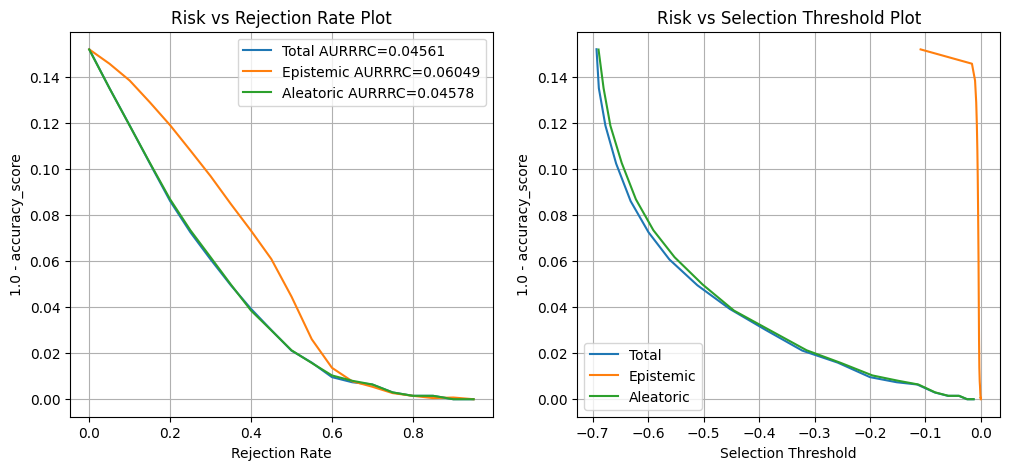

In [20]:
_ = plot_risk_vs_rejection_rate(
    y_true=[all_true_labels_mat, all_true_labels_mat, all_true_labels_mat],
    y_prob=[None, None, None],
    y_pred=[all_pred_labels_mat, all_pred_labels_mat, all_pred_labels_mat],
    selection_scores=[-all_total_mat, -all_epi_mat, -all_aleo_mat],
    plot_label=["Total", "Epistemic", "Aleatoric"],
    risk_func=accuracy_score,
    subgroup_ids=[None, None, None],
    num_bins=20
)

In [21]:
# Doing Calibration
from uq360.algorithms.classification_calibration.classification_calibration import ClassificationCalibration
from uq360.metrics.classification_metrics import plot_reliability_diagram
from scipy.special import softmax

In [22]:
calib_from_features = ClassificationCalibration(
    num_classes=2,
    fit_mode="features",
    base_model_prediction_func=lambda x: softmax(10*bnn.predict(x).y_prob, axis=1)
)

In [23]:
calib_from_features = calib_from_features.fit(X=norm_X_calib, y=y_calib.values)

In [24]:
y_prob_calibrated_from_features = calib_from_features.predict(norm_X_test).y_prob

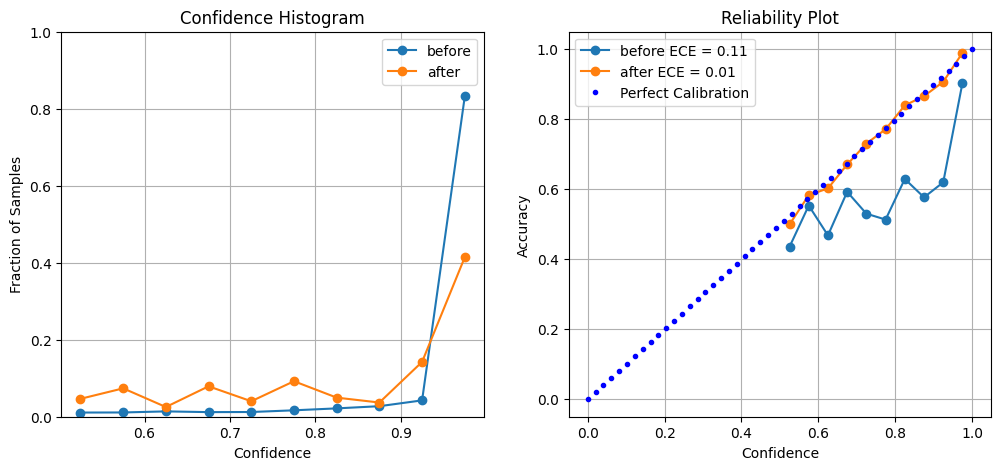

In [25]:
_ = plot_reliability_diagram([y_test, y_test],
                         [softmax(10*bnn.predict(norm_X_test).y_prob, axis=1), y_prob_calibrated_from_features],
                             [None, None],
                         plot_label = ["before", "after"],
                            num_bins=10)